In [1]:
# Read data from google drive 
from google.colab import drive
drive.mount('/content/drive')

import os
# path = '/content/drive/MyDrive/projet_recherche'
path = '/content/drive/MyDrive/ENSIIE/M1/S4/PRR-Projet-Recherche/projet_recherche'
os.chdir(path)

Mounted at /content/drive


# Heston Price 

In [2]:
def Call_Price_Heston(S,K,T,r,kappa,theta,nu,rho,V0,alpha=1,L=1000):
    #P= Price of a call with Maturity T and Strike K using the characteristic function of the 
    #price and the Carr-Madan formula - No FFT used
    #S= Initial price
    #r= risk free rate
    #kappa,theta,nu,rho = parameters Heston
    #V0= initial vol in Heston model
    #alpha = damping factor (alpha >0) typically take alpha=1
    #L = truncation bound for the integral
    
    import numpy as np
    import scipy.integrate as integrate

    i = complex(0,1)
    b=lambda x:(kappa-i*rho*nu*x)
    gamma=lambda x:(np.sqrt(nu**(2)*(x**2+i*x)+b(x)**2))
    a=lambda x:(b(x)/gamma(x))*np.sinh(T*0.5*gamma(x))
    c=lambda x:(gamma(x)*np.cosh(0.5*T*gamma(x))/np.sinh(0.5*T*gamma(x))+b(x))
    d=lambda x:(kappa*theta*T*b(x)/nu**2)

    f=lambda x:(i*(np.log(S)+r*T)*x+d(x))
    g=lambda x:(np.cosh(T* 0.5*gamma(x))+a(x))**(2*kappa*theta/nu**2)
    h=lambda x:(-(x**2+i*x)*V0/c(x))

    phi=lambda x:(np.exp(f(x))*np.exp(h(x))/g(x)) # Characteristic function
    integrand=lambda x:(np.real((phi(x-i*(alpha+1))/((alpha+i*x)*(alpha+1+i*x)))*np.exp(-i*np.log(K)*x)))
    integral = integrate.quad(integrand,0, L)
    P=(np.exp(-r*T-alpha*np.log(K))/np.pi) * integral[0]
    return P

In [3]:
Call_Price_Heston(100,100,1,0,1,0.08,1,-.5,0.08,alpha=1,L=1000) 

8.836959972067445

# Black-Scoles Price

$ \frac{x}{1-x} = \frac{1}{1-x} - 1$

In [10]:
# load packages

import numpy as np
import matplotlib.pyplot as plt 



In [9]:
# BS model Price calculation

def C_BS(sigma, r, S, T, K):
    # sigma : volatility
    # r : risk-free interest
    # S : stock price
    # T : time to maturity
    # K : strike price
    
    import numpy as np
    from scipy.stats import norm
    
    t = 0
    d1 = (1/(sigma*np.sqrt(T-t)))*(np.log(S/K)+(r+(sigma**2)/2)*(T-t))
    d2 = d1-sigma*np.sqrt(T-t)
    
    
    return S*norm.cdf(d1) - K*np.exp(-r*(T-t))*norm.cdf(d2)

In [6]:
C = C_BS(sigma=0.2, r=0, S=100, T=1, K=100 )
C # CALL Price

7.965567455405804

In [7]:
sig = np.linspace(0.01, 10, 100)
C_bs = [C_BS(s, 0, 100, 1, 100) for s in sig]

Text(0, 0.5, 'Black-Scholes Price $C^{BS}$')

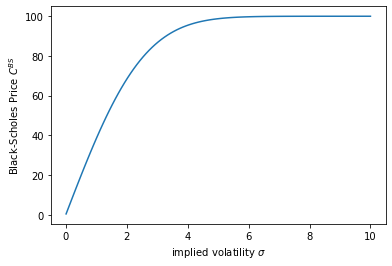

In [8]:
plt.plot(sig, C_bs)
plt.xlabel("implied volatility $\sigma$")
plt.ylabel("Black-Scholes Price $C^{BS}$")

# price -> volatility calculation

In [2]:
# bi-section method searching implied volatility

def imp_vol(C, r, S, T, K, N = 20): 
    # N: iteration number
    # K : strike price
    # T : maturity, in "year"
    # t : present instant
    # r : active risk-free rate
    # S : stock price
    
    import numpy as np
    
    n = N+1
    x = np.zeros(n)
    y = np.ones(n) # index : 0 -> N
#     z = np.zeros(n)
    
    for i in range(1,n): # index : 0 -> N-1
        z = 1/2 * (x[i-1] + y[i-1])
        sig = z/ (1 - z)
        
        if (C > C_BS(sig, r, S, T, K)):
            x[i] = z
            y[i] = y[i-1]
        else:
            x[i] = x[i-1]
            y[i] = z
            
    z = (x[N] + y[N]) / 2
    sigma = z / (1-z)
    return sigma 
        

In [10]:
imp_vol(C=C, r=0, S=100, T=1, K=100)


0.19999977111820771

In [11]:
def vol_vect(K, S,T,r,kappa,theta,nu,rho,V0,alpha=1,L=1000):
    import numpy as np
    
    v = np.zeros(len(K))
    i = 0
    for k in K :
        prix_opt = Call_Price_Heston(S,k,T,r,kappa,theta,nu,rho,V0,alpha=1,L=1000) # always the same model, but with K different
        vol = imp_vol(prix_opt, r, S, T, k, N = 20)
        v[i] = vol
        i += 1
    return v

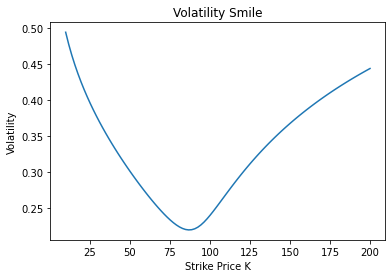

In [12]:
#  vol depend on K

K = np.linspace(10, 200, 100)

S = 100
T = 1
r = 0
kappa = 1
theta = 0.08
nu = 1
rho = .5
V0 = 0.08

vol =  vol_vect(K, S,T,r,kappa,theta,nu,rho,V0,alpha=1,L=1000)

plt.plot(K,vol)
plt.xlabel("Strike Price K")
plt.ylabel("Volatility")
plt.title("Volatility Smile")
plt.show()

## Adding volatilily to the generated prices

In [3]:
import pandas as pd

In [5]:
df = pd.DataFrame()
for i in range(10):
  print('param2_'+str(i+1)+'.csv', 'added to df')
  temp = pd.read_csv('data/param2_'+str(i+1)+'.csv')
  df = pd.concat([df, temp])

param2_1.csv added to df
param2_2.csv added to df
param2_3.csv added to df
param2_4.csv added to df
param2_5.csv added to df
param2_6.csv added to df
param2_7.csv added to df
param2_8.csv added to df
param2_9.csv added to df
param2_10.csv added to df


In [6]:
df.head()

,S,K,m,T,r,rho,kappa,gam,nu,V0,price
0,100.0,109.727579,0.911348,1.289351,0.012616,-0.341331,0.466980,0.570688,0.037302,0.470395,22.052446
1,100.0,121.761607,0.821277,1.748494,0.003466,-0.184956,0.325467,0.269769,0.112852,0.493984,25.489026
2,100.0,75.938311,1.316858,0.718012,0.015625,-0.786272,1.965432,0.464774,0.181610,0.135622,28.586334
3,100.0,75.997247,1.315837,1.180228,0.041085,-0.777110,1.047442,0.168897,0.027497,0.346401,34.370636
4,100.0,101.204579,0.988098,0.699343,0.021379,-0.694197,0.622226,0.649895,0.468941,0.066212,11.764919


In [7]:
df.shape

(100000, 11)

In [11]:
df['impl_vol'] = df.apply(lambda row : imp_vol(C = row['price'], r =  row['r'], 
                                               S = row['S'], T =  row['T'], K = row['K'], N = 20), axis = 1)

In [12]:
df.head()

,S,K,m,T,r,rho,kappa,gam,nu,V0,price,impl_vol
0,100.0,109.727579,0.911348,1.289351,0.012616,-0.341331,0.466980,0.570688,0.037302,0.470395,22.052446,0.557978
1,100.0,121.761607,0.821277,1.748494,0.003466,-0.184956,0.325467,0.269769,0.112852,0.493984,25.489026,0.619066
2,100.0,75.938311,1.316858,0.718012,0.015625,-0.786272,1.965432,0.464774,0.181610,0.135622,28.586334,0.421757
3,100.0,75.997247,1.315837,1.180228,0.041085,-0.777110,1.047442,0.168897,0.027497,0.346401,34.370636,0.468116
4,100.0,101.204579,0.988098,0.699343,0.021379,-0.694197,0.622226,0.649895,0.468941,0.066212,11.764919,0.349931


In [13]:
df.to_csv("data/param2.csv", index = False)